In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import sklearn
import  PIL
from PIL import Image
import os
%matplotlib inline

from unet import *
import keras

c:\users\lenovo\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
VEHICLES = 10 # Data encoding in the segmented image
ROADS = 7
ROAD_LINES = 6

def isolate_cars(filename,i):
    img = Image.open(filename)

    img_np = np.array(img)

    img_np_R = img_np[:,:,0] # Pull out R channel

    img_np_R[img_np_R == VEHICLES] = 255    

    img_np_R[img_np_R != 255] = 0
    
    h,w = img_np_R.shape
    img_np_R[int(.82*h):h, :] = 0

    new_img = np.stack((img_np_R,img_np_R,img_np_R), axis=-1)
    
    image = Image.fromarray(new_img, 'RGB')
    dest = 'mask/'
    image.save(dest+str(i)+'.png')
    return image

In [3]:
'''
i=0
for subdir, dirs, files in os.walk('../lyft_training_data/Train/CameraSeg'):
    for file in files:
        isolate_cars(os.path.join(subdir, file),i)
        i=i+1
'''

"\ni=0\nfor subdir, dirs, files in os.walk('../lyft_training_data/Train/CameraSeg'):\n    for file in files:\n        isolate_cars(os.path.join(subdir, file),i)\n        i=i+1\n"

In [21]:
def preprocess_labels(label_image,obj):
    # Identify lane marking pixels (label is 6)
    lane_marking_pixels = (label_image[:,:,0] == ROAD_LINES).nonzero()
    road_pixels = (label_image[:,:,0] == ROADS).nonzero()
    # Set lane marking pixels to road (label is 7)
    #labels_new = np.zeros_like(label_image)
    #labels_new = np.copy(label_image)
    labels_new = np.zeros([600, 800, 1])
    labels_new[lane_marking_pixels] = ROADS
    if obj=='road' or obj=='both':
        labels_new[road_pixels] = ROADS
 
    # Identify all vehicle pixels
    vehicle_pixels = (label_image[:,:,0] == VEHICLES).nonzero()
    if obj == 'car' or obj=='both':
        labels_new[vehicle_pixels] = VEHICLES
    # Isolate vehicle pixels associated with the hood (y-position > 496)
    hood_indices = (vehicle_pixels[0] >= 496).nonzero()[0]
    hood_pixels = (vehicle_pixels[0][hood_indices], \
                   vehicle_pixels[1][hood_indices])
    # Set hood pixel labels to 0
    labels_new[hood_pixels] = 0
    # Return the preprocessed label image 
    #labels_new = labels_new.reshape(600 * 800, 1)
    return labels_new


def catelab(labels, dims, n_labels):
    x = np.zeros([dims[0], dims[1], n_labels])
    for i in range(dims[0]):
        for j in range(dims[1]):
            x[i, j, labels[i][j]]=1
    x = x.reshape(dims[0] * dims[1], n_labels)
    return x

In [22]:
image = cv2.imread("../lyft_training_data/Train/CameraSeg/900.png")

#image = mpimg.imread("../lyft_training_data/Train/CameraSeg/0.png")
image1= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

[]

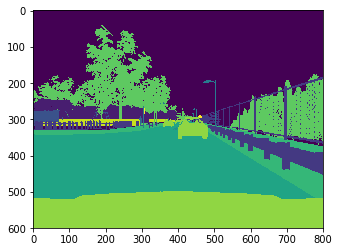

In [23]:
plt.imshow(image1[:,:,0])
plt.plot()

TypeError: Invalid dimensions for image data

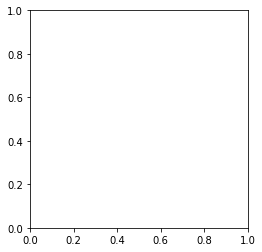

In [24]:
pre = preprocess_labels(image1,'car')
plt.imshow(pre)
plt.plot()

In [27]:
def load_data():
		labels = []
		data = []
		for subdir, dirs, files in os.walk('../lyft_training_data/Train/CameraSeg'):
   			for file in files:
			    image = cv2.imread(os.path.join(subdir, file))
			    image1= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
			    procesed_image=preprocess_labels(image1,'car')
			    labels.append(procesed_image)
		
		for subdir, dirs, files in os.walk('../lyft_training_data/Train/CameraRGB'):
			for file in files:
				image1= cv2.cvtColor(cv2.imread(os.path.join(subdir, file)), cv2.COLOR_BGR2RGB) 
                
				data.append(image1)

		X_train, X_test, y_train, y_test = train_test_split(data,labels, test_size=0.3, shuffle=True)

		return X_train, y_train, X_test

In [28]:
myunet = myUnet(600,800)

In [29]:
#model_unet = myunet.get_unet()
#model_segnet=CreateSegNet(np.shape(pre), 2)
model_s =get_model()
print(model_s)

In [30]:
X_train, y_train, X_test =load_data()

In [31]:
model =myunet.train(X_train, y_train, X_test)

loading data
loading data done
got unet
Fitting model...


F:\SDC\lyft-challenge\semantic-segmentation\unet.py:268: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  model.fit(np.array(imgs_train), np.array(imgs_mask_train), batch_size=4, nb_epoch=10, verbose=1,validation_split=0.2, shuffle=True, callbacks=[model_checkpoint])


Train on 560 samples, validate on 140 samples
Epoch 1/10
560/560 [==============================] - 762s 1s/step - loss: 1.6451 - acc: 0.9640 - val_loss: 1.6753 - val_acc: 0.9627

Epoch 00001: loss improved from inf to 1.64506, saving model to unet.hdf5
Epoch 2/10
560/560 [==============================] - 587s 1s/step - loss: 1.5556 - acc: 0.9499 - val_loss: 1.6038 - val_acc: 0.9436

Epoch 00002: loss improved from 1.64506 to 1.55557, saving model to unet.hdf5
Epoch 3/10
560/560 [==============================] - 625s 1s/step - loss: 1.5142 - acc: 0.9437 - val_loss: 1.5918 - val_acc: 0.9261

Epoch 00003: loss improved from 1.55557 to 1.51415, saving model to unet.hdf5
Epoch 4/10
560/560 [==============================] - 614s 1s/step - loss: 1.4955 - acc: 0.9399 - val_loss: 1.5771 - val_acc: 0.9582

Epoch 00004: loss improved from 1.51415 to 1.49547, saving model to unet.hdf5
Epoch 5/10
560/560 [==============================] - 607s 1s/step - loss: 1.4808 - acc: 0.9379 - val_loss: 1.

In [63]:
 print(np.shape(X_train[0])) 

(600, 800, 3)


In [38]:
 print(np.shape(X_test[0])) 

(600, 800, 3)


In [40]:
model_s.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 600, 800, 3)  0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 600, 800, 1)  28          input_3[0][0]                    
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 600, 800, 1)  0           conv2d_5[0][0]                   
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 600, 800, 64) 640         activation_9[0][0]               
__________________________________________________________________________________________________
activation

In [26]:
pre.shape

(600, 800, 1)

In [44]:
#predicted = model.predict(X_test[50])
imgs_mask_test = model.predict(np.array(X_test), batch_size=1, verbose=1)

300/300 [==============================] - 100s 334ms/step


[]

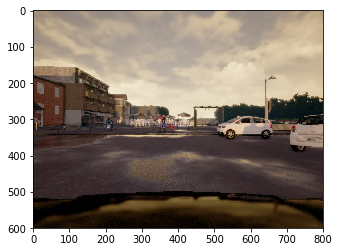

In [45]:
plt.imshow(X_test[40])
plt.plot()

TypeError: Invalid dimensions for image data

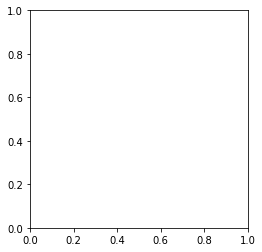

In [62]:
np.shape(imgs_mask_test[0])
new_img = np.stack((imgs_mask_test[0][:,:,0],imgs_mask_test[0][:,:,0],imgs_mask_test[0][:,:,0]),axis=-1)
plt.imshow(y_train[0])
plt.plot()

In [59]:
new_img.shape

(3, 600, 800)

In [55]:
np.shape(imgs_mask_test[0][:,:,0])

(600, 800)

[]

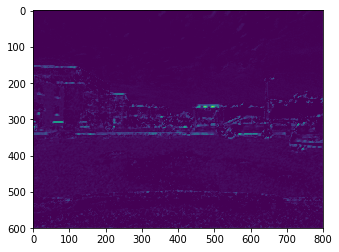

In [61]:
plt.imshow(imgs_mask_test[40][:,:,0])
plt.plot()